## 0. 问题简介及背景知识

### 问题简介

这个项目中我们会利用生成式模型来进行单文档自动摘要，并在**DUC 2004 dataset**上进行模型最终效果的测试。评价指标是ROUGE。最后我们在**DUC2004 TASK 1**应该得到的结果如下：

```
[KEY: > input(description), = target(headline), < output]

> a south korean lawmaker said friday communist north korea could be producing plutonium and could have more secret underground nuclear facilities than already feared .
= s . korea says n . korea could be producing plutonium in underground plants .
< n korea korea korea n . korea korea korea producing plutonium . <EOS>

> egyptian president hosni mubarak met here sunday with syrian president hafez assad to try to defuse growing tension between syria and turkey .
= egypt s mubarak attempts mediation of turkey syria dispute
< egypt s mubarak attempts mediation of turkey syria dispute <EOS>

> police and soldiers on friday blocked off the street in front of a house where members of a terrorist gang are believed to have assembled the bomb that blew up the u .s . embassy killing people .
= suspects in us embassy bombings arrested in dar es salaam and new york
< nobel police american in operative business thai to to to to . <EOS>

> premier romano prodi battled tuesday for any votes freed up from a split in a far left party but said he will resign if he loses a confidence vote expected later this week .
= prodi faces confidence vote break with prodi divides refounding party .
< ecevit confidence confidence vote with business divides be be be . . <EOS>
```

其中`>`为文本输入，`=`为headline，`<`为我们模型的预计输出

我们的模型共分两部分，本篇主要是生成式模型，借鉴了[sequence to sequence network](http://arxiv.org/abs/1409.3215)，seq2seq模型利用两个RNN网络来实现将一个序列转化为另一个序列，其中Encoder网络将输入序列映射为一个向量，Decoder网络将该向量展开为一个新的序列。

在此基础上，我们还引入了[attention 机制](https://arxiv.org/abs/1409.0473)，他可以让decoder专注于输入序列的特定部分，提升模型的效果。

### 背景知识

#### Seq2Seq模型，The Sequence to Sequence model

A [Sequence to Sequence network](http://arxiv.org/abs/1409.3215), or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two separate RNNs called the **encoder** and **decoder**. The encoder reads an input sequence one item at a time, and outputs a vector at each step. The final output of the encoder is kept as the **context** vector. The decoder uses this context vector to produce a sequence of outputs one step at a time.

![](https://i.imgur.com/tVtHhNp.png)

When using a single RNN, there is a one-to-one relationship between inputs and outputs. We would quickly run into problems with different sequence orders and lengths that are common during translation. Consider the simple sentence "Je ne suis pas le chat noir" &rarr; "I am not the black cat". Many of the words have a pretty direct translation, like "chat" &rarr; "cat". However the differing grammars cause words to be in different orders, e.g. "chat noir" and "black cat". There is also the "ne ... pas" &rarr; "not" construction that makes the two sentences have different lengths.

With the seq2seq model, by encoding many inputs into one vector, and decoding from one vector into many outputs, we are freed from the constraints of sequence order and length. The encoded sequence is represented by a single vector, a single point in some N dimensional space of sequences. In an ideal case, this point can be considered the "meaning" of the sequence.

This idea can be extended beyond sequences. Image captioning tasks take an [image as input, and output a description](https://arxiv.org/abs/1411.4555) of the image (img2seq). Some image generation tasks take a [description as input and output a generated image](https://arxiv.org/abs/1511.02793) (seq2img). These models can be referred to more generally as "encoder decoder" networks.

#### 注意力机制，The Attention Mechanism

The fixed-length vector carries the burden of encoding the the entire "meaning" of the input sequence, no matter how long that may be. With all the variance in language, this is a very hard problem. Imagine two nearly identical sentences, twenty words long, with only one word different. Both the encoders and decoders must be nuanced enough to represent that change as a very slightly different point in space.

The **attention mechanism** [introduced by Bahdanau et al.](https://arxiv.org/abs/1409.0473) addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector. For every step the decoder can select a different part of the input sentence to consider.

![](https://i.imgur.com/5y6SCvU.png)

Attention is calculated with another feedforward layer in the decoder. This layer will use the current input and hidden state to create a new vector, which is the same size as the input sequence (in practice, a fixed maximum length). This vector is processed through softmax to create *attention weights*, which are multiplied by the encoders' outputs to create a new context vector, which is then used to predict the next output.

![](https://i.imgur.com/K1qMPxs.png)

## 1. 环境配置

 #### 使用PyTorch设计网络

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

#### 使用NVIDIA 1080ti + CUDA 加速训练

In [21]:
USE_CUDA = True

## 2. 获取及整理数据集

本次任务是在 DUC2004 Task1 上进行单文档摘要提取，由于生成摘要模型部分需要的训练数据较多，因此我们需要利用外部的同源数据集进行训练。这里我们利用`Gigaword`数据集进行训练，从OpenNMT的论坛上[1]可以下载到预处理后的文本，下载解压后我们把数据整理为如下格式：`/train/train.article.txt`  和 `/train/train.title.txt`。 `train.article.txt`每行都是一个新闻(news)，行之间以`\n`分隔，`train.title.txt`中是对应的摘要(title)。

In [3]:
## 训练数据所在位置，注意最后没有文件分隔符'/'
file_path = '/root/sharefolder/data/text_mining/sumdata/train'

#### 建立词表，word indexing

我们需要获取每个单词的index，便于输入网络。因此建立一个`Voc`类，包含几个词典 : `word2index`，`word2count`，`index2word`。其中`word2index`是获取每个单词的index，`index2word`是根据index获取对应的单词，`word2count`是用来记录各个单词的词频，用于后续的低频词筛选。

In [4]:
SOS_token = 0
EOS_token = 1

class Voc:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

#### 读取数据，Reading and decoding files

数据是以`Unicode`存储的，为了简化我们进行一些预处理，包括：转化为ASCII编码、小写化、去掉部分标点符号等

In [5]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

接下来我们需要读入数据，并将文本按行分开，将每行新闻文本(new)和其对应摘要(title)作为一个pair，用于后续训练。因此需要设计一个可以读取文本、整合pair的函数，我们添加了一个`reverse`字段用于逆序组合（`reverse`为`True`时一个pair中文本在前，摘要在后，即：[new,title]）。

In [6]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines1 = open(file_path+'/%s.txt' % lang1, encoding='utf8').read().strip().split('\n')
    lines2 = open(file_path+'/%s.txt' % lang2, encoding='utf8').read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(lines1[x]), normalize_string(lines2[x])] for x in range(len(lines1))]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        voc = Voc(lang1+lang2)
    else:
        voc = Voc(lang1+lang2)
        
    return voc, pairs

#### 筛选句子，Filtering sentences

考虑以下两点：
- 该部分模型是作为合成模型的第二部分，从抽取式模型抽取的重要句子中生成式产生摘要，因此我们输入也应该尽可能短一些。
- 数据量很大，为了先出一版结果快速迭代，也应该采用小量数据便于加快训练速度。

因此我们选择的最大训练新闻文本长度为50个tokens（包括标点）。

In [7]:
MAX_LENGTH = 50

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH 

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

#### 数据预处理步骤汇总，preprocessing pipeline

数据预处理的pipeline如下：

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [8]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    voc, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        voc.index_words(pair[0])
        voc.index_words(pair[1])

    return voc, pairs

voc, pairs = prepare_data('train.title', 'train.article', True)

# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 3803957 sentence pairs
Trimmed to 3749418 sentence pairs
Indexing words...
['india s economy will continue to grow at an percent rate in coming years but the government is worried about the sharp rise in unemployment over the past decade of the boom an official report said monday .', 'india s economy likely to sustain high growth but rising unemployment worries government']


## 3. 映射词向量

为了训练seq2seq网络，我们需要把单词映射为向量。将每个句子转化为张量（Tensor），具体做法是先将句子分词，然后利用之前设计的word2index找到每个tokens对应的index，再将这些index组合起来形成Tensor。在创建Tensor时我们还需要在句子最后加上`EOS`字符代表句子结束。

![](https://i.imgur.com/LzocpGH.png)

Tensor是个多维度的数组，并且可以被定义为不同格式，比如LongTensor，FloatTensor等。再本项目中我们利用LongTensor来表示词向量。

PyTorch模型利用变量（Variable）作为输入（而不是Plain Tensor），Variable本身是一个能记录动态流图状态的Tensor，这个特性有助于实现自动反向求导。可以去了解一下PyTorch中的autograd机制，有助于理解。autograd全称为automatic calculation of backwards gradients。

下面我们设计三个函数来实现从tokens到tensor乃至variable的转换：`indexes_from_sentence`用来实现从句子提取单词并转化为对应的index；`variable_from_sentence`用来实现从句子生成Variable；`variables_from_pair`用来从每个pair中生成新闻文本（new）和摘要（title）的Variable，用于最终训练。

In [9]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(voc, sentence):
    indexes = indexes_from_sentence(voc, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(voc, pair[0])
    target_variable = variable_from_sentence(voc, pair[1])
    return (input_variable, target_variable)

**注意**，我们这里只是简单的利用词表中的index来生成词向量，并没有利用Google的word2vec来生成词向量。这样做的原因是出于快速迭代的考虑，先简单实现一个版本看看效果如何。后续`3. 映射词向量`这一部分会利用word2vec来做词向量的映射。

至此，我们的数据整理和词向量映射的部分已经结束，下一步就是利用PyTorch构建模型结构用于训练了。

## 4. 建立模型

模型采用的是引入attention机制的encoder-decoder模型，这里分为几个部分介绍。

### Encoder

seq2seq模型的encoder的输出是输入对应的一个映射，对于每个输入encoder都会生成一个向量和上一个时刻的隐层状态向量（hidden state），通过hidden layer计算生成当前时刻的隐层状态向量并作为下一个时刻的输入。

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

### Attention Decoder

#### Interpreting the Luong et al. model(s)

[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) by Luong et al. describe a few more attention models that offer improvements and simplifications. They describe a few "global attention" models, the distinction between them being the way the attention scores are calculated.

The general form of the attention calculation relies on the target (decoder) side hidden state and corresponding source (encoder) side state, normalized over all states to get values summing to 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

The specific "score" function that compares two states is either *dot*, a simple dot product between the states; *general*, a a dot product between the decoder hidden state and a linear transform of the encoder state; or *concat*, a dot product between a new parameter $v_a$ and a linear transform of the states concatenated together.

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

The modular definition of these scoring functions gives us an opportunity to build specific attention module that can switch between the different score methods. The input to this module is always the hidden state (of the decoder RNN) and set of encoder outputs.

根据Luong等人提出的attention model，我们有几种计算attention score的方式，我们先新建一个`Attn`类来实现对不同attention score计算方式的选择。

In [58]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super().__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if method == 'general':
            self.attn = nn.Linear(hidden_size, hidden_size)
        elif method == 'concat':
            self.attn = nn.Linear(hidden_size*2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(hidden_size))
    
    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)
        attn_energies = Variable(torch.zeros(seq_len)).cuda()
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            return hidden.squeeze().dot(encoder_output.squeeze())
        if self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.squeeze().dot(energy.squeeze())
            return  energy
        if self.method == 'concat':
            energy = self.attn(torch.cat(hidden, encoder_output), 1)
            energy = self.other.dot(energy.squeeze())
            return energy

有了`Attn`类后，我们就可以将`Attn`机制结合近RNN的计算中，用于计算attention weights和相应的context vector。我们利用`AttnDecoderRNN`来实现这一功能。

In [59]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_mode, hidden_size, output_size, n_layers=1, dropout=0.1):
        super().__init__()
        # Parameters
        self.attn_mode = attn_mode
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        #Attn mode
        if attn_mode != None:
            self.attn = Attn(attn_mode, hidden_size)
            
    def forward(self, word_input, last_hidden, last_context, encoder_outputs):
        word_embeded = self.embedding(word_input).view(1, 1, -1)
        
        rnn_input = torch.cat((word_embeded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)
        
        attn_weight = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weight.bmm(encoder_outputs.transpose(0, 1))
        
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        return output, context, hidden, attn_weight

### 测试模型

GPU模式下，训练之前的单元测试，保证之前的代码work

In [62]:
encoder_test = EncoderRNN(10, 10, 2).cuda()
decoder_test = AttnDecoderRNN('general', 10, 10, 2).cuda()
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input =  Variable(torch.LongTensor([1, 2, 3])).cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size)).cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_input[i], decoder_hidden,
                                                                               decoder_context, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear (20 -> 10)
  (attn): Attn (
    (attn): Linear (10 -> 10)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


## 5. 训练模型

In [74]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, decoder_context, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, decoder_context, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [70]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

### 训练参数

In [71]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(voc.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, voc.n_words, n_layers, dropout=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [72]:
# Configuring training
n_epochs = 5000
plot_every = 20
print_every = 100

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

### let's rock and roll

In [75]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

1m 32s (- 75m 50s) (100 2%) 6.8014
1m 59s (- 47m 54s) (200 4%) 6.3355
2m 28s (- 38m 38s) (300 6%) 6.7437
2m 57s (- 33m 56s) (400 8%) 7.0656
3m 30s (- 31m 32s) (500 10%) 7.3752
4m 0s (- 29m 26s) (600 12%) 6.9194
4m 31s (- 27m 49s) (700 14%) 6.8330
5m 2s (- 26m 30s) (800 16%) 6.9392
5m 34s (- 25m 25s) (900 18%) 7.1335
6m 6s (- 24m 25s) (1000 20%) 7.0122
6m 30s (- 23m 5s) (1100 22%) 6.4654
6m 53s (- 21m 50s) (1200 24%) 6.7949
7m 15s (- 20m 38s) (1300 26%) 6.7883
7m 36s (- 19m 33s) (1400 28%) 6.5448
7m 59s (- 18m 38s) (1500 30%) 7.0451
8m 21s (- 17m 46s) (1600 32%) 6.9646
8m 43s (- 16m 56s) (1700 34%) 6.6098
9m 6s (- 16m 11s) (1800 36%) 6.4907
9m 27s (- 15m 25s) (1900 38%) 6.3540
9m 50s (- 14m 46s) (2000 40%) 6.8652
10m 14s (- 14m 8s) (2100 42%) 6.7396
10m 37s (- 13m 31s) (2200 44%) 6.9873
11m 0s (- 12m 55s) (2300 46%) 6.7732
11m 22s (- 12m 19s) (2400 48%) 6.7640
11m 46s (- 11m 46s) (2500 50%) 6.7424
12m 10s (- 11m 13s) (2600 52%) 6.9917
12m 31s (- 10m 40s) (2700 54%) 6.4561
12m 54s (- 10m

### Train loss

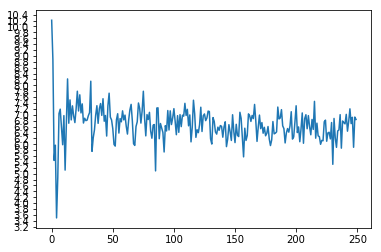

In [76]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

## 6. 评价模型效果

评价模型效果，即evaluating model，过程和训练模型几乎一致，但是没有target headling供我们训练。我们需要循环把decoder的输出作为下一步decoder的输入，每次decoder生成一个单词（词向量）后，我们就把他加入到输出序列中，直到decoder生成 EOS token 后我们就停止输出。我们把每一步的attention weight都保存了下来，用于最后可视化。

In [78]:
def evaluate(sentence, max_length=200):
    input_variable = variable_from_sentence(voc, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, decoder_context, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(voc.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

设计一个随机评价模型的函数：

In [79]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [84]:
evaluate_randomly()

> indonesian president abdurrahman wahid tuesday opened the g summit here with a brief speech and then asked vice president megawati soekarnoputri to read a written statement which she refused .
= indonesian president opens g summit
< u .s to to to in <EOS>



## 7. 可视化attention weights

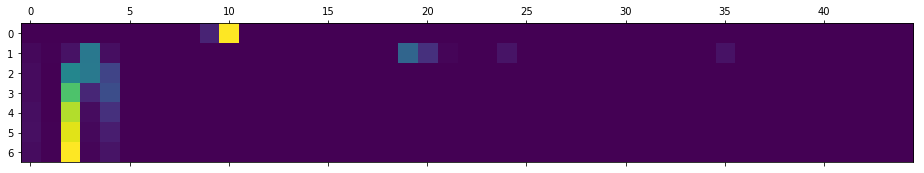

In [85]:
output_words, attentions = evaluate("house speaker newt gingrich who orchestrated the republican revolution of recent years and is overseeing the impeachment inquiry into president clinton was driven from office friday by a party that swiftly turned on him after its unexpected losses in tuesday s midterm elections .")
plt.matshow(attentions.numpy())

In [86]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence, output_words, attentions)

input = a south korean lawmaker said friday communist north korea could be producing plutonium and could have more secret underground nuclear facilities than already feared .
output = u .s to to in in <EOS>


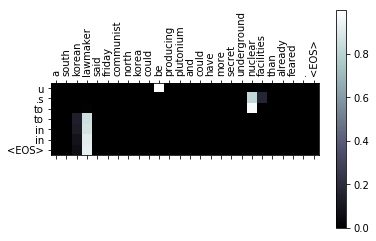

In [87]:
evaluate_and_show_attention("a south korean lawmaker said friday communist north korea could be producing plutonium and could have more secret underground nuclear facilities than already feared .")

## 引用

[].http://arxiv.org/abs/1409.3215)

[].https://arxiv.org/pdf/1406.1078v3.pdf

[].https://arxiv.org/abs/1409.047

[1]. http://forum.opennmt.net/t/text-summarization-on-gigaword-and-rouge-scoring/85
